# PREDICTING PLAYERS PERFORMANCE MEDAL

### ABOUT THE DATASET
📊The dataset used in this project is a simulated Mobile Legends player performance dataset, specifically created to analyze and predict player rankings, represented as medals, based on in-game performance statistics.

📊This dataset was synthesized using ChatGPT, ensuring a clean and well-structured collection of data for modeling purposes. It contains a total of 5,000 individual player records, each uniquely identified and accompanied by performance metrics such as the number of kills, deaths, and assists in a match.

📊The primary goal of this dataset is to provide a realistic yet controlled environment for studying the relationship between a player’s in-game actions and the resulting performance tier, making it suitable for classification tasks and predictive modeling in a gaming analytics context.


### DATASET DESCRIPTION
| **Variable Name**     | **Description**                                  |
| --------------------- | ------------------------------------------------ |
| **kills**             | Number of kills achieved by the player. |
| **death**              | Number of deaths experienced by the player.                |
| **assist**                | Number of assists contributed to teammates’ kills.                        |
| **label**                | Categorical variable indicating the player’s performance tier: bronze, silver, or gold, derived from a KDA-based scoring formula:                            |
|                 | Score=2×kills+assists−deaths                            |

In [38]:
# =====================================================
# STEP 1. Import libraries
# =====================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from google.colab import files

In [39]:
# =====================================================
# STEP 2. Import and Run CSV
# =====================================================
# Upload your CSV File
print("Please upload your CSV file:")
uploaded = files.upload()

# Read uploaded CSV file
fname = list(uploaded.keys())[0]
df = pd.read_csv('mldataset.csv')

# Preview first few rows
print("\nPreview of Uploaded Data:")
display(df.head())

print("\nColumns in Dataset:", list(df.columns))

Please upload your CSV file:


Saving mldataset.csv to mldataset (3).csv

Preview of Uploaded Data:


,player_number,kills,death,assist,label
0,1,6,4,9,silver
1,2,6,6,6,silver
2,3,4,6,8,bronze
3,4,5,2,8,silver
4,5,4,7,7,bronze



Columns in Dataset: ['player_number', 'kills', 'death', 'assist', 'label']


In [40]:
# =====================================================
# STEP 3. Perform Data Cleaning
# =====================================================
# Show dataset infp
print(df.info())
print("=" * 50)

# Check for any null-values
df_clean = df.dropna()
print(df.isnull().sum())
print(df_clean.isnull().sum())
print("=" * 50)

# Check for any duplicate values
duplicates_count = df.duplicated().sum()
print("\n--- Duplicates Count ---")
print(f"Number of duplicate rows: {duplicates_count}")
print("=" * 50)

# Remove if there are any duplicates
if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")
print("=" * 50)

# Remove if there are any outliears
def remove_outliers_zscore(df, columns, threshold=3):
    df_clean = df.copy()
    for col in columns:
        z = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
        df_clean = df_clean[(np.abs(z) < threshold)]  # keep only values within threshold
    return df_clean

for col in ["kills", "death", "assist"]:
    z = (df[col] - df[col].mean()) / df[col].std()
    df = df[np.abs(z) < 3]
print(df_clean)
print("=" * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   player_number  5000 non-null   int64 
 1   kills          5000 non-null   int64 
 2   death          5000 non-null   int64 
 3   assist         5000 non-null   int64 
 4   label          5000 non-null   object
dtypes: int64(4), object(1)
memory usage: 195.4+ KB
None
player_number    0
kills            0
death            0
assist           0
label            0
dtype: int64
player_number    0
kills            0
death            0
assist           0
label            0
dtype: int64

--- Duplicates Count ---
Number of duplicate rows: 0
      player_number  kills  death  assist   label
0                 1      6      4       9  silver
1                 2      6      6       6  silver
2                 3      4      6       8  bronze
3                 4      5      2       8  silver
4               

In [41]:
# =====================================================
# STEP 3. Normalize predictors
# =====================================================
# Exclude 'player_number' column because it will not used for scaling
X = df[['kills','death','assist']]
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_norm = pd.DataFrame(X_scaled, columns=X.columns)

display(X_norm.head())

,kills,death,assist
0,0.010920,0.027880,0.379983
1,0.010920,1.075629,-0.714396
2,-0.822544,1.075629,0.015190
3,-0.405812,-1.019869,0.015190
4,-0.822544,1.599504,-0.349603



Correlation matrix:
            kills     death    assist
kills   1.000000 -0.005183  0.007616
death  -0.005183  1.000000 -0.034778
assist  0.007616 -0.034778  1.000000


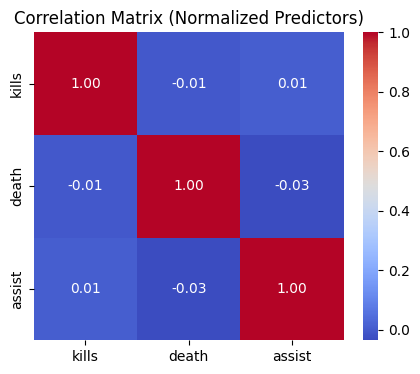

In [42]:
# =====================================================
# STEP 4. Check correlation between predictors
# =====================================================
corr = X_norm.corr()
print("\nCorrelation matrix:\n", corr)

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (Normalized Predictors)")
plt.show()

In [43]:
# =====================================================
# STEP 5. Check Variance Inflation Factor (VIF)
# =====================================================
vif = pd.DataFrame()
vif["Variable"] = X_norm.columns
vif["VIF"] = [variance_inflation_factor(X_norm.values, i) for i in range(X_norm.shape[1])]
print("\nVariance Inflation Factors:\n", vif)


Variance Inflation Factors:
   Variable       VIF
0    kills  1.000082
1    death  1.001235
2   assist  1.001266


In [44]:
# =====================================================
# STEP 6. Split Features (X) and Label (y)
# =====================================================
y = df['label'].copy()

print("\nFeatures (X_norm) shape:", X_norm.shape)
print("Target (y) shape:", y.shape)


Features (X_norm) shape: (4923, 3)
Target (y) shape: (4923,)


In [45]:
# =====================================================
# STEP 7. Split into Training and Testing Sets
# =====================================================
# 80% training data, 20% testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining Records: {len(X_train)} | Testing Records: {len(X_test)}")


Training Records: 3938 | Testing Records: 985


In [46]:
# =====================================================
# STEP 8. Model Training
# =====================================================
from sklearn.linear_model import LogisticRegression

# Fit the Linear Regression model using training data
model = LogisticRegression()
model.fit(X_train, y_train)

print("✅ Model trained successfully!")

✅ Model trained successfully!


In [47]:
# =====================================================
# STEP 10. Predict on Test Data
# =====================================================
# Generate predictions on unseen test data
Y_pred = model.predict(X_test)

print("✅ Prediction complete!")

✅ Prediction complete!


In [48]:
# =====================================================
# STEP 11. Evaluate Model
# =====================================================
from sklearn.metrics import accuracy_score, classification_report

# Compute key classification metrics
accuracy = accuracy_score(y_test, Y_pred)

print(f"\nModel Evaluation Metrics:")
print(f"Accuracy Score: {accuracy:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, Y_pred))



Model Evaluation Metrics:
Accuracy Score: 1.000

Classification Report:
              precision    recall  f1-score   support

      bronze       1.00      1.00      1.00       170
        gold       1.00      1.00      1.00       219
      silver       1.00      1.00      1.00       596

    accuracy                           1.00       985
   macro avg       1.00      1.00      1.00       985
weighted avg       1.00      1.00      1.00       985

